This Jupyter notebook transcript demonstrates the functionality of `phase_ret.py` in an example phase retrieval routine. The data used here is a sample from measurements done for Lens A.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import scipy.optimize as op
from phase_ret import *
plt.set_cmap('viridis')

def imshow_grid(imgs, frac=1., clims=None):
    """A wrapper to conveniently display zoomed images in a grid."""
    n = len(imgs)
    fig = plt.figure(figsize=(4*n, 3))
    img_grid = ImageGrid(fig, 111, nrows_ncols=(1, n), axes_pad=.75, 
                         cbar_mode='each', cbar_pad='5%')
    for i, (ax, cbar, img) in enumerate(zip(img_grid, 
                                            img_grid.cbar_axes, 
                                            imgs)):
        N = img.shape[0] / 2.
        M = img.shape[1] / 2.
        im = ax.imshow(img, extent=(-M, M, N, -N), 
                       interpolation='nearest')
        ax.set_xlim(-frac*M, frac*M)
        ax.set_ylim(-frac*N, frac*N)
        if (clims is not None) and (clims[i] is not None):
            im.set_clim(clims[i])
        cbar.colorbar(im)

C:\Anaconda\lib\site-packages\tifffile\tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


## Estimating the focal plane position
Defocused pinhole images are loaded from a sample data file. The function `analyze_peaks` provides normalized peak intensities, which are then used to fit a $\mathrm{sinc}^2$ function and estimate the focal plane location. Images in the file `focus.tif` were taken with a 1 mm spacing.

In [2]:
stack = TiffFile('focus.tif')
Z = np.arange(len(stack))   # 1 mm spacing
par, var = analyze_peaks(stack, 64, 16)

parameters:

             amp        x0        y0           bg       tot power  norm amp
0    8735.575666  743.7500  802.5625  1288.228135  2080772.308695  0.004198
1   13569.406334  744.5625  801.3750  1280.330212  2015615.765579  0.006732
2   17905.412659  745.0000  799.9375  1315.005822  1900195.121608  0.009423
3   22462.116762  745.3125  798.3125  1309.819521  1820623.280261  0.012338
4   26710.770890  746.0000  797.0000  1225.229110  1782164.058562  0.014988
5   30112.283857  746.2500  795.7500  1222.129575  1754683.877347  0.017161
6   34063.202038  748.0000  793.9375  1224.909355  1774517.158417  0.019196
7   37400.810899  750.0000  791.9375  1230.678269  1831684.576327  0.020419
8   38102.544903  753.8750  791.3750  1258.374553  1833668.920007  0.020779
9   38466.278081  751.1250  788.6875  1240.726324  1854658.912887  0.020740
10  35595.145719  751.5625  787.3750  1238.001921  1827872.612783  0.019474
11  33597.588537  752.1250  785.6250  1238.260642  1883572.987914  0.017837

In [3]:
def sinc2(x, A, a, x0, B):
    """sinc^2 function for fitting to through-focus intensities."""
    return A * np.sinc(a * (x-x0))**2 + B

A = 0.0205290018954 +/- 0.0013508116974
a = 0.0738711914425 +/- 0.00425579363678
x0 = 8.36814933251 +/- 0.0510345924066
B = 0.000255803879106 +/- 0.00143723742567


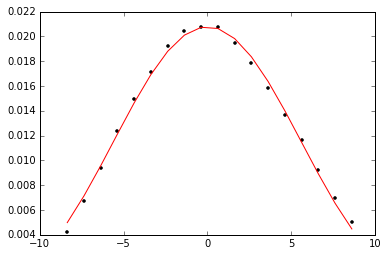

In [4]:
pfit, cfit = op.curve_fit(sinc2, Z, par['norm amp'].astype('float64'), 
                          p0=(2e-2, .5e-3, (Z[0]+Z[-1])/2., 0.))
plt.plot(Z-pfit[2], par['norm amp'], 'k.')
plt.plot(Z-pfit[2], sinc2(Z, *pfit), 'r-')
for pname, p, s in zip(('A', 'a', 'x0', 'B'), 
                       pfit, np.sqrt(np.diag(cfit))):
    print pname, '=', p, '+/-', s

## Preparing images
Images are cropped to the specified size, each frame is centered at the maximum. Then, backgrounds are subtracted and images are normalized. A square root of each of them is taken to get complex amplitudes.

In [5]:
### Some physical quantities and settings are defined here.
dx = 6.8         # Pixel size [um]
z0 = 473000./dx  # Distance to the exit pupil [px]
wl = .766/dx     # Wavelength [px]
N = 256          # Image width [px]
n = 4            # Number of images to be used in a single optimization
tr = Transforms(N, n-1, 2)  # Preparing FFTs.

In [6]:
# Transforming distances to values in pixels 
# relative to the focal plane position.
Z = (Z - pfit[2]) * 1e+3 / dx     
F = np.zeros((len(stack), N, N), dtype=np.float64)
for i, page in enumerate(stack):
    img = crop(page.asarray(), 
               *par.loc[i,'x0':'y0'], s=N).astype(np.complex128)
    img = np.sqrt((img - par.loc[i,'bg']) / par.loc[i,'tot power'])
    # Conserving the zero-mean noise to avoid bias. 
    # Negative values in amplitudes are allowed.
    F[i] = img.real - img.imag

Picking 4 images for optimization, including the master plane determined by index `j`.

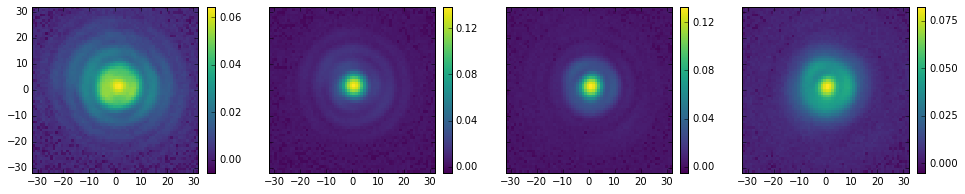

In [7]:
idx = np.array([0, 6, 11, 16])
j = idx[0]
imshow_grid(F[idx], frac=.25)

## Phase retrieveal
Phase in the master plane is estimated via non-linear optimization.

In [8]:
def err(ph, F, Z, j, idx, niter, nout):
    """Error metric for non-linear optimization 
    of the master plane phase.
    
    Args:
        ph: The phase to be optimized.
        F: The whole dataset of complex amplitudes.
        Z: Image positions.
        j: Index of the master plane.
        idx: Array of indiced of images taking part in optimization.
            Has to contain the master plane index too.
        niter: Iteration counter, for displaying convergence info.
        nout: Number of iterations between printing the convergence info.
        
    Returns:
        E: The normalized error metric.
        dE: Norm of the gradient.
    """
    ph = ph.reshape((N,N))
    zk = Z[idx[idx!=j]]
    zj = Z[j]
    Gj = tr.ifftshift(F[j] * np.exp(1.j * ph))
    Fk = tr.ifftshift(F[idx[idx!=j]], axes=(-2, -1))
    sumFk2 = np.sum(Fk**2)
    
    # ASP of master plane field to other planes.
    # Done manually, since Tk is reused later on.
    Tk = np.exp(2.j * np.pi * (zk - zj)[:,None,None] 
                * np.sqrt(1./wl**2 - (tr.x**2 + tr.y**2) / N**2))
    Gkj = tr.ifftn(tr.fft(Gj) * Tk)
    # Squared rms error and gradient
    E = np.sum((Fk - np.abs(Gkj))**2) / sumFk2
    Gwjk = tr.ifftn(tr.fftn((
                Fk * np.exp(1.j * np.angle(Gkj))  - Gkj)) * Tk.conj())
    dE = tr.fftshift(2. * np.imag(
            Gj * np.sum(Gwjk.conj(), axis=0)) / sumFk2)
    
    # Print convergence info.
    if not niter[0]%nout:
        print niter[0], '\t', E, '\t', np.abs(dE).max()
    niter[0] += 1
    return E, dE.ravel()

The optimization routine starts with random uniform phase. The L-BFGS method is used to minimize the error metric.

In [9]:
ph0 = 2. * np.pi * (np.random.rand(N**2) - .5)
niter = [0]
nout = 50
opt_ph = op.minimize(err, x0=ph0, args=(F, Z, j, idx, niter, nout), 
                     method='L-BFGS-B', jac=True, 
                     options={'maxiter':500})

0 	1.62165528138 	0.0039204041197
50 	0.418682584339 	0.000860527854209
100 	0.345128553167 	0.000549222561301
150 	0.318384471282 	0.000446227126602
200 	0.305172707842 	0.000399707794932
250 	0.297437596517 	0.00023713556931
300 	0.292217497868 	0.000285978080652
350 	0.288391656398 	0.000154128185388
400 	0.285485963851 	0.000262486003511
450 	0.283344804148 	0.000201288491915
500 	0.281689792188 	8.5449475648e-05


Phase in the master plane is obtained directly from the optimization algorithm.

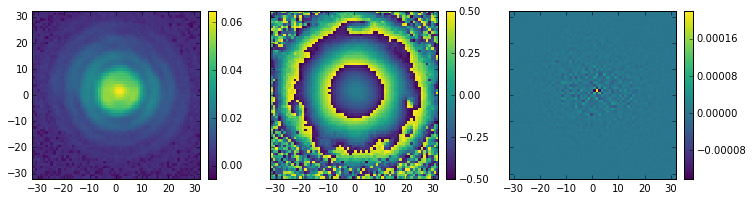

In [10]:
ph = opt_ph.x.reshape((N,N))
ph_jac = opt_ph.jac.reshape((N,N))
# This wraps the phase, making it easier to display on a graph.
P = np.exp(1.j*ph)  
imshow_grid((F[j], np.angle(P)/2./np.pi, ph_jac), frac=.25)

**Left:** master plane amplitude. **Center:** reconstructed phase in wavelengths. **Right:** gradient after the last iteration.

ASP to the focal plane and backward Fraunhofer diffraction to the exit pupil yield the exit pupil field, whose complex phase corresponds to the wavefront aberration.

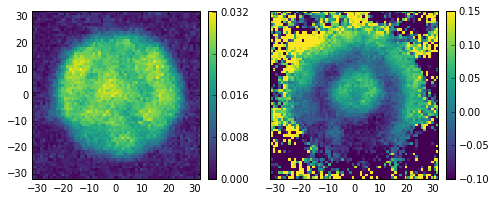

In [11]:
G0 = tr.fraun(tr.asp(F[j] * P, -Z[j], wl), -z0, wl)
# This roughly subtracts the piston, better for displaying.
G0 *= np.exp(-1.j * np.angle(np.sum(G0)))
imshow_grid((np.abs(G0), np.angle(G0)/2./np.pi), 
            frac=.25, clims=(None, (-.1,.15)))

**Left:** pupil field amplitude. **Right:** phase in wavelengths, i.e. the wavefront error.

## Pupil radius and location

A top-hat function representing the circular opening of the exit pupil is fitted. This allows to extract the pupil radius and a spatial shift due to phase tilts in the focal plane.

In [12]:
def fit_circ((A, B, dx, dy, a), img):
    circ = circle(N/2+dx, N/2+dy, a, N)*A + B
    return (circ - img).ravel()

A = 0.019706217439
B = 0.00226400245599
dx = 0.0952255377025
dy = -0.0481228115257
a = 24.0000145875


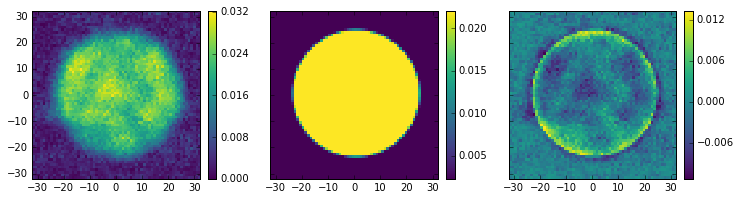

In [13]:
opt_circ = op.leastsq(fit_circ, (abs(G0).max(), 0., 0., 0., 30), 
                      args=(abs(G0),), full_output=True)
res_circ = opt_circ[2]['fvec'].reshape((N,N))  # residuals
imshow_grid((abs(G0), abs(G0)+res_circ, res_circ), frac=.25)
for pname, p in zip(('A', 'B', 'dx', 'dy', 'a'), opt_circ[0]):
    print pname, '=', p
a = opt_circ[0][-1]

**Left:** exit pupil amplitude. **Center:** the fitted top-hat. **Right:** fit residuals.

The fitted pupil location is used to correct phase tilts in the focal plane. Reconstruction is then repeated, resulting in the pupil being centered. This may not be necessary in this case, but in two-image reconstructions pupil shifts may be significantly larger.

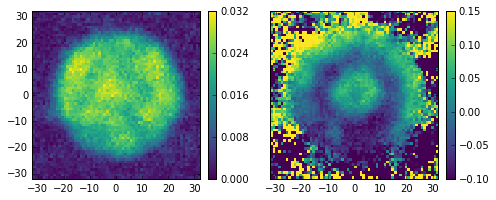

In [14]:
# This is a Fourier shift.
S = tr.fftshift(np.exp(2.j * np.pi * (tr.x*opt_circ[0][2] 
                                      + tr.y*opt_circ[0][3]) / N))
G0 = tr.fraun(tr.asp(F[j] * P, -Z[j], wl) * S, -z0, wl)
G0 *= np.exp(-1.j * np.angle(np.sum(G0)))
imshow_grid((np.abs(G0), np.angle(G0)/2./np.pi), 
            frac=.25, clims=(None, (-.1,.15)))

## Extracting Zernike polynomial expansion coefficients
The RMS wavefront error is calculated from the coefficients:  
$W_\mathrm{RMS} = \sqrt{\sum_{j=4}^{j_\mathrm{max}} c_j^2}$,  
starting from $c_4$, since piston and tilts do not represent true aberrations.  

This allows to approximate the Strehl ratio: $S\approx e^{-(2\pi W_\mathrm{RMS})^2}$.  
The object space Airy disk radius in um is calculated from the fitted pupil aperture radius and known magnification.

Wrms = 0.0358645895004
S = 0.950487891662
r0 = 0.787283032748


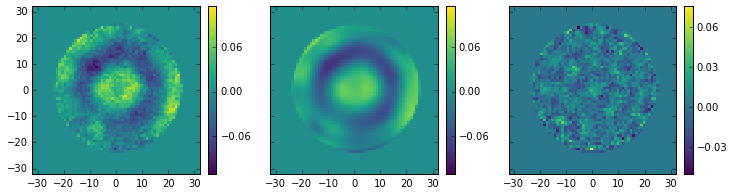

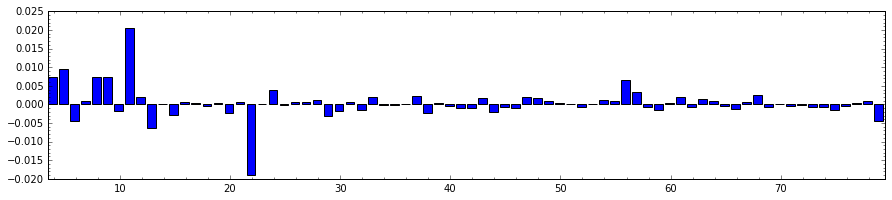

In [15]:
jmax = 79
zern = Zernike(jmax, a, N)
W0 = np.angle(G0)/2./np.pi  # the original wavefront
C = zern.fit(np.angle(G0)/2./np.pi, jmax)
# Setting to zero outside the pupil, ignoring piston and tilts.
W = zern(np.concatenate(((0,0,0), C[3:]))) * zern.R  
G0 *= np.exp(-2.j*np.pi * zern(C[:3])) # Removing piston and tilts.
W0 = np.angle(G0)/2./np.pi * zern.R

# Wavefronts set to zero outside the pupil
imshow_grid((W0, W, W - W0), frac=.25, 
            clims=((W0.min(),W0.max()),(W0.min(),W0.max()),None)) 
plt.figure(figsize=(15,3))
plt.bar(np.arange(3,jmax)+.5, C[3:])
plt.xlim(3.5, jmax+.5)
plt.minorticks_on()

Wrms = np.sqrt(np.sum(C[3:]**2))
Strehl = np.exp(-(2. * np.pi * Wrms)**2)
r0 = .61*N/a * dx / 56.20
print 'Wrms =', Wrms
print 'S =', Strehl
print 'r0 =', r0

**Left:** the original wavefront with piston and tilts removed. **Center:** Zernike fit. **Right:** fit residuals. Phase in wavelengths, set to zero outside the pupil.  
**Bottom:** expansion coefficients.